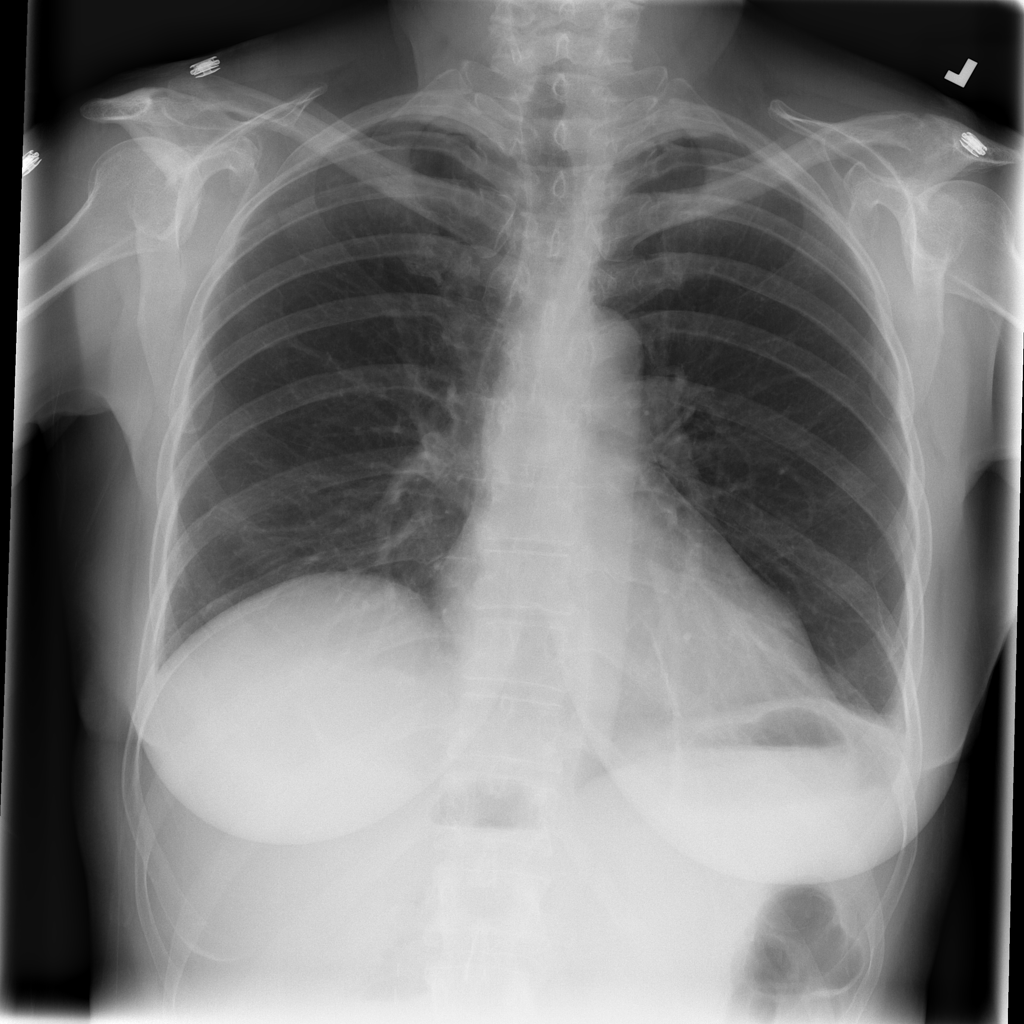

In [1]:
from PIL import Image

img = Image.open("bbox_list_img/00000147_001.png")
img = img.convert("RGB")
img

In [2]:
import torch
from transformers import ViTFeatureExtractor, ViTModel

device = "cuda" if torch.cuda.is_available() else "cpu"
feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

print(f"Models loaded on {device}")


c:\Data\NIH_Chest_X-rays\chest_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Data\NIH_Chest_X-rays\chest_venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded on cpu


In [3]:
img_tensor = feature_extractor(img, return_tensors="pt").to(device)
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding



array([ 0.3530885 ,  0.8201806 , -0.5723813 ,  0.97355705,  0.23834999,
       -0.9193596 ,  0.83688736,  0.64353025,  0.46548   , -0.9936553 ,
        0.61943376, -0.3317076 , -0.84178805, -0.999565  , -0.30202782,
       -0.08222321, -0.38136795,  0.7219255 , -0.7956953 , -0.7760031 ,
       -0.29391193, -0.25715336,  0.01736645, -0.5930088 , -0.96449435,
       -0.98817503, -0.2969536 ,  0.8504724 ,  0.1360478 , -0.93210775,
        0.9204905 , -0.84680575, -0.99496406, -0.9951862 ,  0.06656724,
        0.8325524 , -0.6740977 , -0.9604342 , -0.99520355,  0.11734325,
       -0.9996221 ,  0.9999805 ,  0.30348122, -0.9973413 ,  0.9875076 ,
        0.64163333, -0.63978994,  0.8088072 ,  0.9931772 ,  0.821129  ,
        0.39351672,  0.93782353, -0.9179827 ,  0.8301499 , -0.9510183 ,
        0.96489805, -0.81316644,  0.9890893 ,  0.91422546, -0.9998737 ,
       -0.9947087 , -0.5640395 ,  0.9796614 ,  0.09259824, -0.9463686 ,
       -0.98145366,  0.6821765 ,  0.9987337 , -0.16183378,  0.82

In [4]:
embedding.shape

(384,)

In [5]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("sample_chest_embed")



In [6]:
from glob import glob

img_list = glob("bbox_list_img/*.png")

len(img_list)










880

In [8]:
if img.mode != 'RGB':
    img = img.convert('RGB')

In [9]:
from tqdm import tqdm
import os
embeddings = []
metadata = []
ids = []


for i, img_path in enumerate(tqdm(img_list)):
    try:
        img = Image.open(img_path)
        if img.mode != 'RGB':
            img = img.convert('RGB')
        cls = os.path.normpath(img_path).split(os.sep)[-2]

        img_tensor = feature_extractor(images=img, return_tensors="pt")
        outputs = model(**img_tensor)
        embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

        embeddings.append(embedding)
        metadata.append({
            "uri": img_path,
            "cls": cls
        })
        ids.append(str(i))
    except Exception as e:
        print(f"[ERROR] Failed on {img_path}: {e}")


print("Done!")










100%|██████████| 880/880 [01:18<00:00, 11.18it/s]

Done!


In [10]:
print(embeddings[0].shape)  
print(metadata[0])

(384,)
{'uri': 'bbox_list_img\\00000032_037.png', 'cls': 'bbox_list_img'}


In [11]:
collection.add(
    ids=ids,
    embeddings=embeddings,
    metadatas=metadata
)


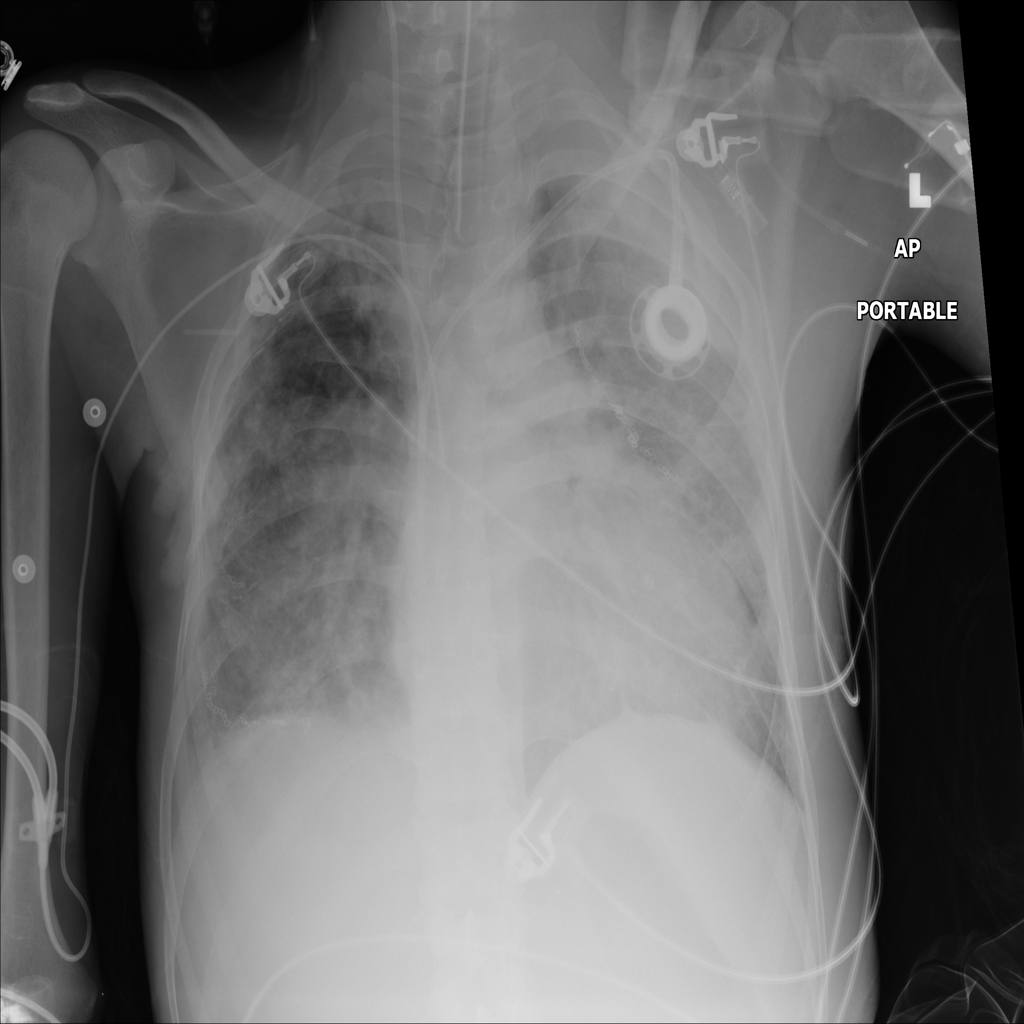

In [15]:
test_img = Image.open("bbox_list_img/00009608_024.png")
test_img = test_img.convert("RGB")
test_img

In [16]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()
test_embedding.shape


(384,)

In [24]:
query_result = collection.query(
    query_embeddings=[test_embedding],
    n_results=5
)

query_result






{'ids': [['186', '843', '328', '533', '268']],
 'embeddings': None,
 'documents': [[None, None, None, None, None]],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'cls': 'bbox_list_img',
    'uri': 'bbox_list_img\\00009608_024.png'},
   {'cls': 'bbox_list_img', 'uri': 'bbox_list_img\\00029588_004.png'},
   {'uri': 'bbox_list_img\\00013670_151.png', 'cls': 'bbox_list_img'},
   {'uri': 'bbox_list_img\\00019018_007.png', 'cls': 'bbox_list_img'},
   {'uri': 'bbox_list_img\\00012141_013.png', 'cls': 'bbox_list_img'}]],
 'distances': [[0.0,
   72.08195495605469,
   75.498291015625,
   79.3431396484375,
   79.76436614990234]]}

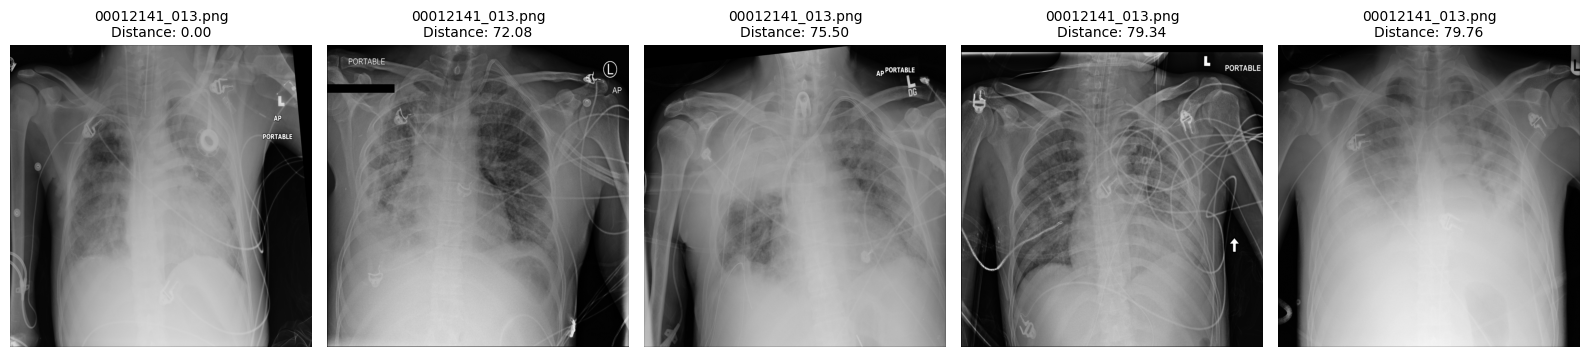

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    img_id = os.path.basename(img_path)
    distance = query_result["distances"][0][i]
    axes[i].imshow(
    Image.open(metadata["uri"]), 
    cmap="gray"           # ← 여기에 gray 컬러맵을 명시
    )
    axes[i].set_title(f"{metadata['uri']} : Distance: {distance:.2f}")
    axes[i].set_title(f"{img_id}\nDistance: {query_result['distances'][0][i]:.2f}", fontsize=10)
    axes[i].axis("off")

plt.tight_layout()
plt.show()



In [22]:
import pandas as pd
df = pd.read_csv('BBox_List_2017_renamed.csv')

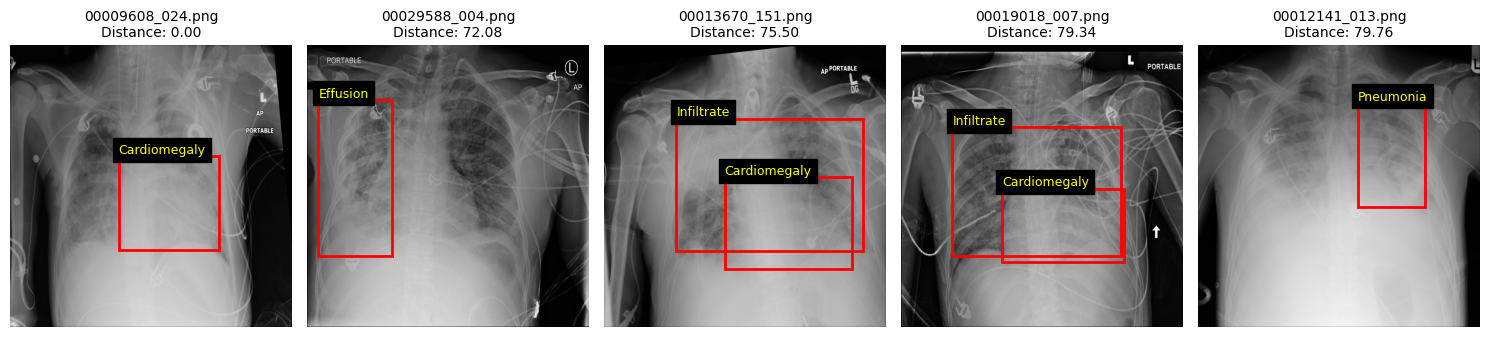

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

# 상위 3개 유사 이미지
selected_images = [metadata["uri"] for metadata in query_result["metadatas"][0]]

plt.figure(figsize=(15, 5))  # 가로로 넓게
cols = 5
rows = 1

for idx, img_path in enumerate(selected_images):
    image = Image.open(img_path)
    
    ax = plt.subplot(rows, cols, idx + 1)
    ax.imshow(image, cmap="gray")
    ax.axis('off')
    
    # 파일명에서 이미지 ID 추출
    img_id = os.path.basename(img_path)
    ax.set_title(f"{img_id}\nDistance: {query_result['distances'][0][idx]:.2f}", fontsize=10)
    
    # 바운딩 박스 그리기
    bbox_rows = df[df['Image Index'] == img_id]
    for _, row in bbox_rows.iterrows():
        rect = patches.Rectangle(
            (row['x'], row['y']), row['w'], row['h'],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(row['x'], row['y'] - 10, row['Finding Label'],
                color='yellow', fontsize=9, backgroundcolor='black')

plt.tight_layout()
plt.show()


In [ ]:
# 1. Cardiomegaly
# 2. Effusion
# 3. Infiltrate, Cardiomegaly